# Generate samples for a single scene

In [1]:
import sys
import os
import pylab as plt
import numpy as np
from matplotlib.colors import ListedColormap
from osgeo import gdal
from osgeo import ogr
from importlib import reload
from shapely.geometry import Polygon
from shapely.wkb import loads
import skimage

sys.path.insert(0, '../src')
import deepleeo.dataset.data_augment as dtaug
import deepleeo.dataset.rasterizer as rstzr
import deepleeo.dataset.sampleGenerator as sg
import deepleeo.utils.filesystem as fs

reload(dtaug)
reload(rstzr)
reload(sg)
reload(fs)

%matplotlib inline

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input Files
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real')
shape_file = os.path.join(DATA_DIR, 'PRODES2016_225-64_REP.shp')
raster_file = os.path.join(DATA_DIR, "Landsat8_225-64_17-07-2016-B1-7.tif")
class_column = "agregClass"

# Output Files
output_path = os.path.join(DATA_DIR, 'generated')
fs.mkdir(output_path)
output_shp = os.path.join(output_path, "samples.shp")
output_npz = os.path.join(output_path, "samples_dataset.npz")

number_of_samples = 5000
window_size = 128

## Rasterize the input shape file

In [3]:
rasterizer = rstzr.Rasterizer(shape_file, raster_file, class_column)
rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

Raster Shape: (7741, 7591, 1)


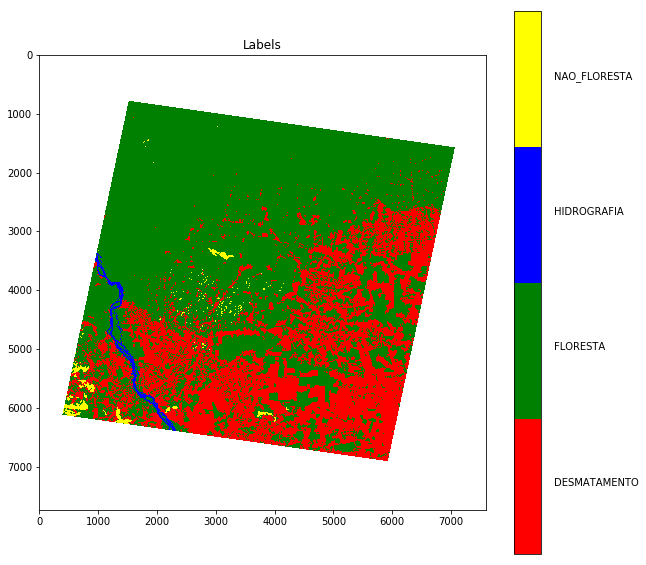

In [4]:
plt.figure(figsize=(10, 10))
plt.title('Labels')
print("Raster Shape:", rasterized_layer.shape)
labels = np.ma.masked_where(rasterized_layer == 255, rasterized_layer)

colorMap = ListedColormap(["red", "green", "blue", "yellow"])
plt.imshow(rasterized_layer[:,:,0], cmap=colorMap)
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(class_names):
    cbar.ax.text(1.5, (2 * j + 1) / 8, lab, ha='left')

cbar.ax.get_yaxis().labelpad = 15

In [5]:
raster_ds = gdal.Open(raster_file)
raster_img = raster_ds.ReadAsArray()
raster_img = np.rollaxis(raster_img, 0, start=3)
smpGen = sg.SampleGenerator(raster_img, rasterized_layer, class_names, raster_file)
smpGen.compute_sample_indexes(number_of_samples)
smpGen.extract_windows(window_size)
smpGen.save_samples_SHP(output_shp)
smpGen.save_samples_NPZ(output_npz)

In [6]:
# - Create execute method. 
# - Implement method to save to geotiff. In this method, allow the user to pass a list of indexes to save (none saves everything)

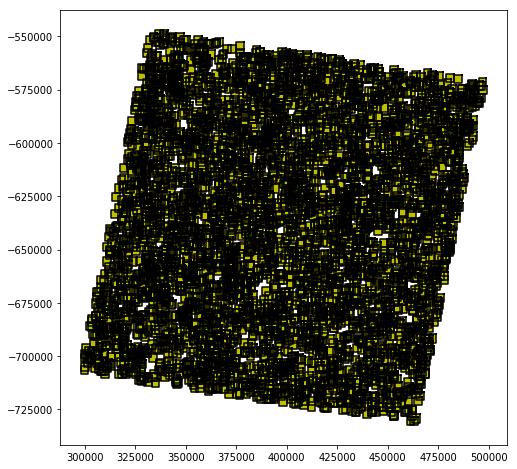

In [7]:
#TODO: How to plot the raster together? Decrease the blank space from the origin to the data
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
out_ds = ogr.Open(output_shp)

layer = out_ds.GetLayerByName(os.path.splitext(os.path.basename(output_shp))[0])
parcel = layer.GetNextFeature()

while parcel is not None:
    polygon = loads(parcel.GetGeometryRef().ExportToWkb())
    xCoord , yCoord = polygon.exterior.xy
    ax.fill(xCoord,yCoord,"y")
    ax.plot(xCoord,yCoord, "k-")
    parcel = layer.GetNextFeature()

out_ds.Destroy()

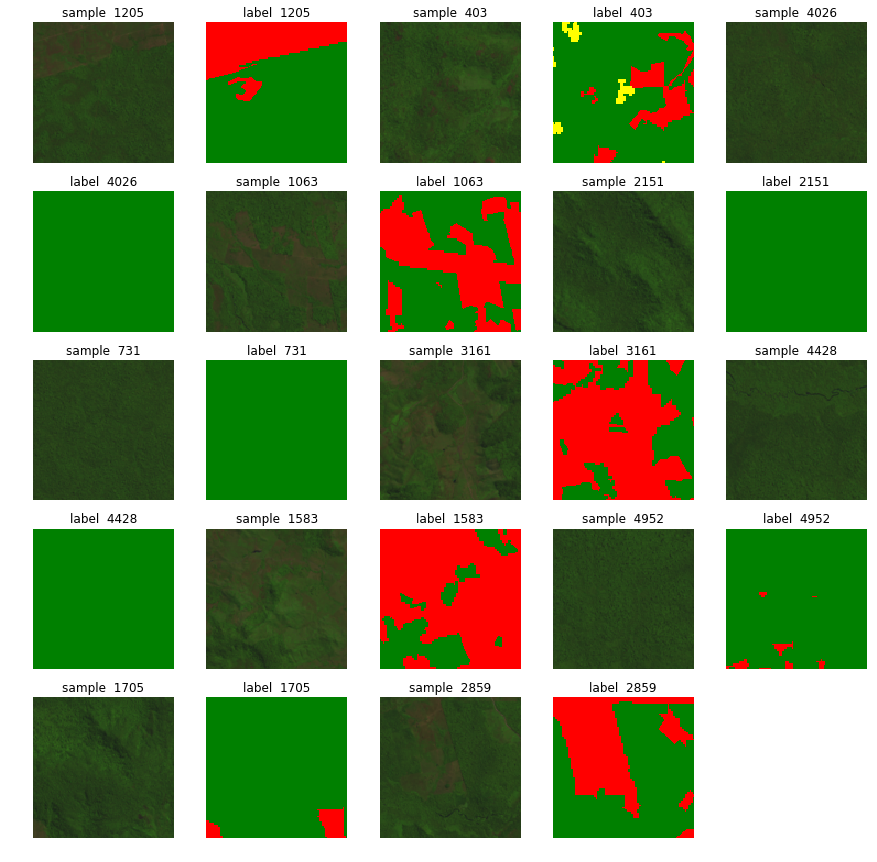

In [18]:
samples = smpGen.getSamples()
plt.figure(figsize=(15,15))

#TODO: Some samples has no data value only in labels. Is it necessary to remove no data or clip the base raster?
# Why is the forest being printed in yellow?? Search for how to set colors by values. It seems to be by range
colorList = ["red", "green", "blue", "yellow"]
count = 1
for x in range(1, 13):
    pos = np.random.randint(len(samples["img_samples"]))
    smpImg = samples["img_samples"][pos]
    smpImg = skimage.img_as_float(smpImg).astype(np.float32)
    plt.subplot(5, 5, count)
    plt.title("%s %d" % ("sample ", pos))
    plt.axis('off')
    plt.imshow(smpImg[:,:,[5,4,3]], interpolation='nearest')
    count=count+1
    
    lblImg = samples["labels"][pos]
    plt.subplot(5, 5, count)
    plt.title("%s %d" % ("label ", pos))
    plt.axis('off')
    # Mounting the color map for this sample
    palette = []
    for val in np.unique(lblImg):
        if not val == 255:
            #print("VAL: ", val)
            #print("ColorList[val]: ", colorList[val])
            palette.append(colorList[val])
    colorMap = ListedColormap(palette)
    plt.imshow(lblImg[:,:,0], interpolation='nearest', cmap=colorMap)
    count=count+1

# Cells bellow here make the data augmentation

Their code must be moved to a .py file. Move it to the sampleGenerator? Or create a file to the data augmentation? The Data Augmentation must be done when generating the dataset or when training the network? Put the samples generated with data augmentation in the dataset generate them on the fly? 

## About the implementation
The data augmentation over the samples must be done together with the labels. How to ensure the order in the dataset?

Instructions for updating:
Use the retry module or similar alternatives.


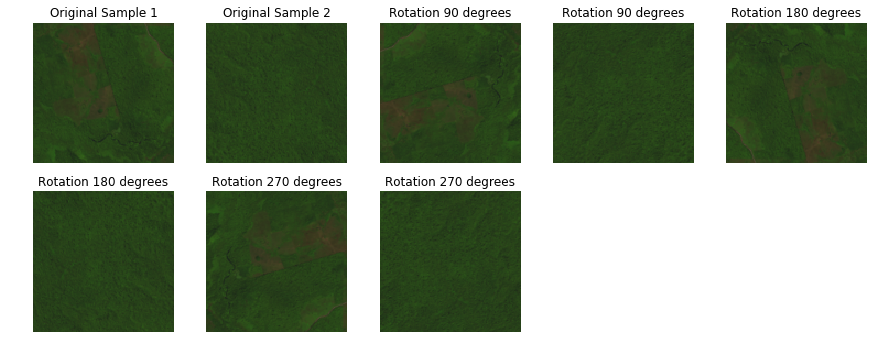

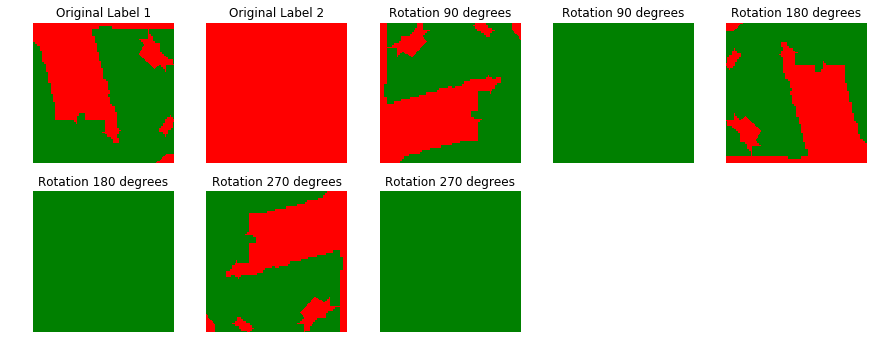

In [19]:
smp_imgs = samples["img_samples"][2859:2861]
lbl_imgs = samples["labels"][2859:2861]
for idx in range(len(smp_imgs)):
    smp_imgs[idx] = skimage.img_as_float(smp_imgs[idx]).astype(np.float32)

plt.figure(figsize=(15,15))
    
for idx in range(len(smp_imgs)):
    plt.subplot(5, 5, (idx+1))
    plt.title('Original Sample %d' % (idx + 1))
    plt.imshow(smp_imgs[idx][:,:,[5, 4, 3]], interpolation='nearest')
    plt.axis('off')

angles = [90, 180, 270]
rotated_imgs = dtaug.rotate_images(smp_imgs, angles)
samples["img_samples"].extend(rotated_imgs)

pos_ang = 0
for idx in range(len(rotated_imgs)):
    if(idx % 2 == 0 and idx != 0):
        pos_ang = pos_ang + 1
    plt.subplot(5, 5, (idx + len(smp_imgs) + 1))
    plt.title("Rotation %d degrees" % (angles[pos_ang]))
    plt.imshow(rotated_imgs[idx][:,:,[5, 4, 3]], interpolation='nearest')
    plt.axis('off')
    
plt.figure(figsize=(15,15))
    
for idx in range(len(lbl_imgs)):
    # Mounting the color map for this sample
    palette = []
    for val in np.unique(lbl_imgs):
        if not val == 255:
            palette.append(colorList[val])
    colorMap = ListedColormap(palette)
    
    plt.subplot(5, 5, (idx+1))
    plt.title('Original Label %d' % (idx + 1))
    plt.imshow(lbl_imgs[idx][:,:,0], interpolation='nearest', cmap = colorMap)
    plt.axis('off')

rotated_lbls = dtaug.rotate_images(lbl_imgs, angles, data_type=np.int32)
samples["labels"].extend(rotated_lbls)
    
pos_ang = 0
for idx in range(len(rotated_lbls)):
    if(idx % 2 == 0 and idx != 0):
        pos_ang = pos_ang + 1
        
    # Mounting the color map for this sample
    palette = []
    for val in np.unique(rotated_lbls[idx]):
        if not val == 255:
            palette.append(colorList[int(val)])
    colorMap = ListedColormap(palette)
    
    plt.subplot(5, 5, (idx + len(smp_imgs) + 1))
    plt.title("Rotation %d degrees" % (angles[pos_ang]))
    plt.imshow(rotated_lbls[idx][:,:,0], interpolation='nearest', cmap = colorMap)
    plt.axis('off')

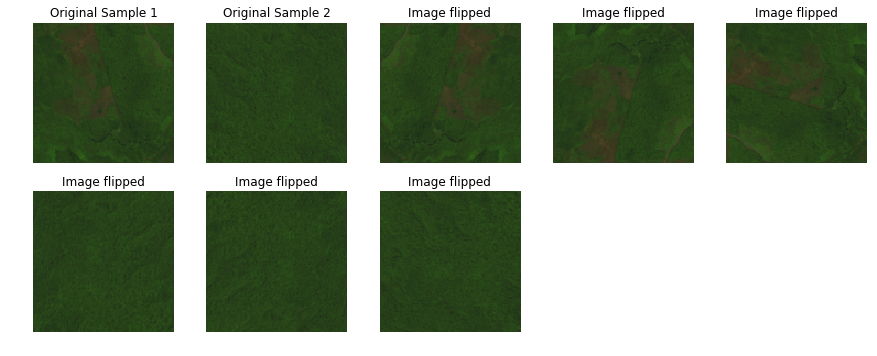

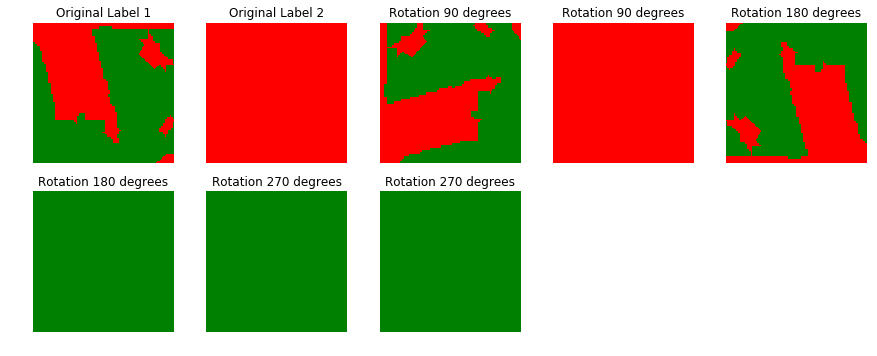

In [20]:
plt.figure(figsize=(15,15))
    
for idx in range(len(smp_imgs)):
    plt.subplot(5, 5, (idx+1))
    plt.title('Original Sample %d' % (idx + 1))
    plt.imshow(smp_imgs[idx][:,:,[5, 4, 3]], interpolation='nearest')
    plt.axis('off')

flipped_imgs = dtaug.flip_images(smp_imgs)
samples["img_samples"].extend(flipped_imgs)

for idx in range(len(flipped_imgs)):
    plt.subplot(5, 5, (idx + len(smp_imgs) + 1))
    plt.title("Image flipped")
    plt.imshow(flipped_imgs[idx][:,:,[5, 4, 3]], interpolation='nearest')
    plt.axis('off')
    
plt.figure(figsize=(15,15))
    
for idx in range(len(lbl_imgs)):
    # Mounting the color map for this sample
    palette = []
    for val in np.unique(lbl_imgs):
        if not val == 255:
            palette.append(colorList[val])
    colorMap = ListedColormap(palette)
    
    plt.subplot(5, 5, (idx+1))
    plt.title('Original Label %d' % (idx + 1))
    plt.imshow(lbl_imgs[idx][:,:,0], interpolation='nearest', cmap = colorMap)
    plt.axis('off')

flipped_lbls = dtaug.flip_images(lbl_imgs)
samples["labels"].extend(flipped_lbls)
    
pos_ang = 0
for idx in range(len(flipped_lbls)):
    if(idx % 2 == 0 and idx != 0):
        pos_ang = pos_ang + 1
        
    # Mounting the color map for this sample
    palette = []
    for val in np.unique(flipped_lbls[idx]):
        if not val == 255:
            palette.append(colorList[int(val)])
    colorMap = ListedColormap(palette)
    
    plt.subplot(5, 5, (idx + len(smp_imgs) + 1))
    plt.title("Rotation %d degrees" % (angles[pos_ang]))
    plt.imshow(rotated_lbls[idx][:,:,0], interpolation='nearest', cmap = colorMap)
    plt.axis('off')

In [22]:
print(len(samples["img_samples"]))
print(len(samples["labels"]))

5012
5012
